In [1]:
# SPDX-License-Identifier: BSD-3-Clause

# This Jupyter notebook is licensed under the BSD 3-Clause License.
# You may use, modify, and redistribute it under the conditions in the LICENSE file.

# 1. Setup

In [1]:
#import the necessary libraries
import os
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import integrate
import seaborn as sns
import polars as pl
import pymc as pm
import arviz as az
import pytensor as pt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# version check
print(f"Numpy {np.__version__}")
print(f"Matplotlib {matplotlib.__version__}")
print(f"Scipy {scipy.__version__}")
print(f"Seaborn {sns.__version__}")
print(f"Polars {pl.__version__}")
print(f"PyMC {pm.__version__}")
print(f"Arviz {az.__version__}")
print(f"PyTensor {pt.__version__}")

Numpy 1.24.4
Matplotlib 3.7.5
Scipy 1.10.1
Seaborn 0.13.2
Polars 1.8.2
PyMC 5.6.1
Arviz 0.15.1
PyTensor 2.12.3


In [46]:
#set parameters for plotting
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.titlesize'] = 12

In [4]:
#scan the csv file
path = "all_B2045_calibrated.csv"
queries = pl.scan_csv(path, separator=" ", has_header=False, new_columns=['subint', 'chan', 'bin', 'amp'], skip_rows=1)

print(queries.head().collect())

shape: (5, 4)
┌────────┬──────┬─────┬──────────┐
│ subint ┆ chan ┆ bin ┆ amp      │
│ ---    ┆ ---  ┆ --- ┆ ---      │
│ i64    ┆ i64  ┆ i64 ┆ f64      │
╞════════╪══════╪═════╪══════════╡
│ 0      ┆ 0    ┆ 0   ┆ 3.39553  │
│ 0      ┆ 0    ┆ 1   ┆ 29.3019  │
│ 0      ┆ 0    ┆ 2   ┆ 31.2606  │
│ 0      ┆ 0    ┆ 3   ┆ -14.901  │
│ 0      ┆ 0    ┆ 4   ┆ -41.5779 │
└────────┴──────┴─────┴──────────┘


# 2. Examine Pulses

In [5]:
#manipulate into each sub-integration
data = queries.group_by("subint", maintain_order=True).agg(pl.col("amp"))

print(data.head().collect())

shape: (5, 2)
┌────────┬─────────────────────────────────┐
│ subint ┆ amp                             │
│ ---    ┆ ---                             │
│ i64    ┆ list[f64]                       │
╞════════╪═════════════════════════════════╡
│ 0      ┆ [3.39553, 29.3019, … -24.1017]  │
│ 1      ┆ [-100.815, -1.28699, … -128.83… │
│ 2      ┆ [-34.2546, -21.8881, … -18.402… │
│ 3      ┆ [-28.8718, -52.1777, … 7.33166… │
│ 4      ┆ [-70.865, -66.6728, … -49.6535… │
└────────┴─────────────────────────────────┘


<Axes: >

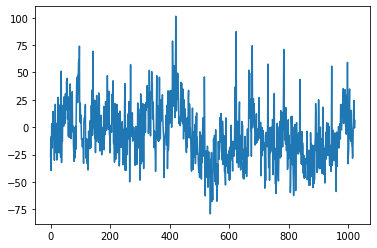

In [6]:
#sample plot if a single pulse
sns.lineplot(data.select("amp").collect()["amp"][28])

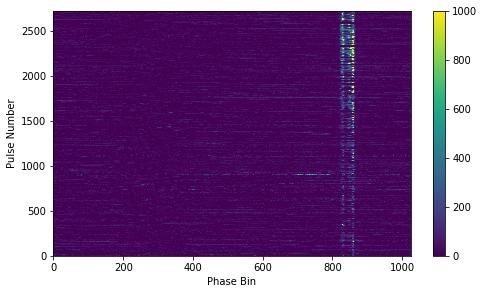

In [7]:
#time domain plot of pulses
plt.figure(figsize=(8, 4.5))

plt.pcolormesh([row["amp"] for row in data.select("amp").collect().iter_rows(named=True)], vmax=1000, vmin=0, cmap='viridis')
plt.xlabel("Phase Bin")
plt.ylabel("Pulse Number")
plt.colorbar()


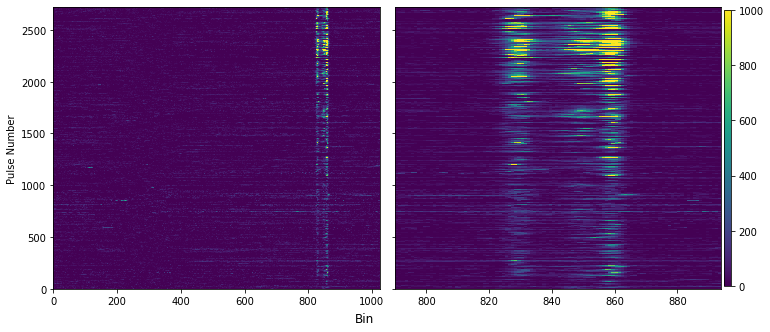

In [8]:
#bin 0-1024 (left) and zoomed (right)
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, layout='compressed')

fig.set_figheight(4.5)
fig.set_figwidth(10)

ax[0].pcolormesh([row["amp"] for row in data.select("amp").collect().iter_rows(named=True)], vmax=1000, vmin=0, cmap='viridis')
im = ax[1].pcolormesh([row["amp"] for row in data.select("amp").collect().iter_rows(named=True)], vmax=1000, vmin=0, cmap='viridis')
ax[1].set_xlim(790, 894)

fig.supxlabel("Bin", fontsize=12)
ax[0].set_ylabel("Pulse Number")

cbar_ax = fig.add_axes([1, 0.13, 0.01, 0.85])
fig.colorbar(im, cax=cbar_ax)


# 3. Create Folded Pulse Profile

In [9]:
#sum the amplitude of each bin
integrated_pulse = queries.group_by("bin", maintain_order=True).agg(pl.col("amp").mean())

print(integrated_pulse.head().collect())

shape: (5, 2)
┌─────┬───────────┐
│ bin ┆ amp       │
│ --- ┆ ---       │
│ i64 ┆ f64       │
╞═════╪═══════════╡
│ 0   ┆ 10.042792 │
│ 1   ┆ 9.819768  │
│ 2   ┆ 8.460302  │
│ 3   ┆ 13.677063 │
│ 4   ┆ 2.515786  │
└─────┴───────────┘


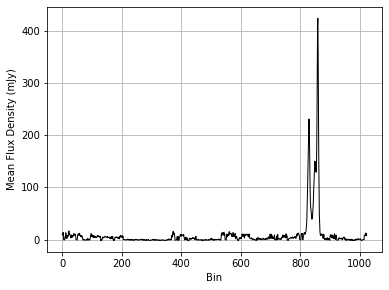

In [10]:
#plot the integrated amplitude
plt.figure(figsize=(6, 4.5))

norm_integrated_pulse = integrated_pulse.select("amp").collect()["amp"]

sns.lineplot(norm_integrated_pulse, linewidth=1, color='#000000', alpha=1)
plt.xlabel('Bin')
plt.ylabel('Mean Flux Density (mJy)')
plt.grid()

In [11]:
#exclude pulse 901
flt_integrated_pulse = queries.filter(pl.col("subint") != 901).group_by("bin", maintain_order=True).agg(pl.col("amp").mean())

print(flt_integrated_pulse.head().collect())

shape: (5, 2)
┌─────┬──────────┐
│ bin ┆ amp      │
│ --- ┆ ---      │
│ i64 ┆ f64      │
╞═════╪══════════╡
│ 0   ┆ 1.597878 │
│ 1   ┆ 1.278593 │
│ 2   ┆ 0.956246 │
│ 3   ┆ 1.231427 │
│ 4   ┆ 1.155752 │
└─────┴──────────┘


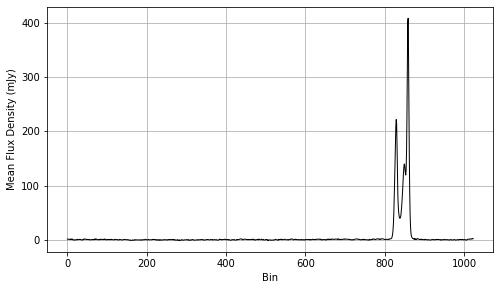

In [12]:
#plot the integrated amplitude again
plt.figure(figsize=(8, 4.5))

flt_norm_integrated_pulse = flt_integrated_pulse.select("amp").collect()["amp"]

sns.lineplot(flt_norm_integrated_pulse, linewidth=1, color='#000000', alpha=1)
plt.xlabel('Bin')
plt.ylabel('Mean Flux Density (mJy)')
plt.grid()

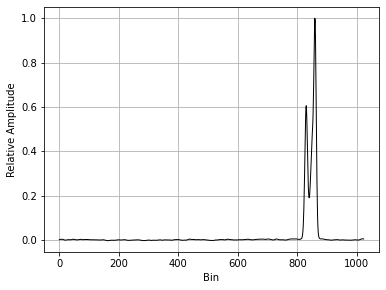

In [13]:
#smooth out the profile using gaussian convolution
plt.figure(figsize=(6, 4.5))

dx = 1
sigma = 3
gx = np.arange(-3*sigma, 3*sigma, dx)
gaussian = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(gx/sigma)**2/2)

conv = np.convolve(flt_norm_integrated_pulse, gaussian, 'same')
norm_conv = conv / conv.max()

sns.lineplot(norm_conv, linewidth=1, color='#000000', alpha=1)
plt.xlabel('Bin')
plt.ylabel('Relative Amplitude')
plt.grid()

# 4. Separate the on-pulse from the off-pulse

initial 820
1 804
initial 870
1 880


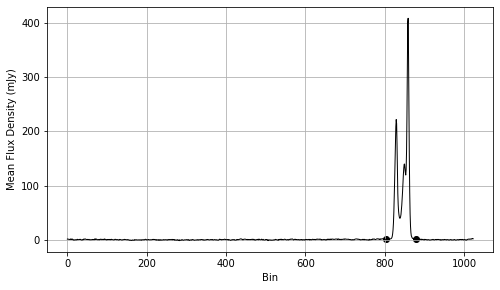

In [14]:
#find the beginning and the end of the on-pulse
plt.figure(figsize=(8, 4.5))

point = [[], []]

first = [norm_conv[i+1]-norm_conv[i-1] for i in range(1, 1023)]

begin_1 = 0
for i, v in enumerate(first):
    if v > 0.04:
      if begin_1 == i-1:
        begin_1 += 1
        print('initial', begin_1)
        point[1].append((begin_1, flt_norm_integrated_pulse[begin_1]))
        break
      begin_1 = i

begin = 0
for i, v in reversed(list(enumerate(first[:begin_1]))):
    if v < 0:
      if begin == i+1:
        print(1, begin+1)
        point[0].append((begin+1, flt_norm_integrated_pulse[begin+1]))
        break
      begin = i

end_1 = 0
for i, v in reversed(list(enumerate(first))):
    if v < -0.04:
      if end_1 == i+1:
        end_1 += 1
        print('initial', end_1)
        point[1].append((end_1, flt_norm_integrated_pulse[end_1]))
        break
      end_1 = i

end = 0
for i, v in enumerate(first[end_1:], end_1):
    if v > 0:
      if end == i-1:
        end += 1
        print(1, end)
        point[0].append((end, flt_norm_integrated_pulse[end]))
        break
      end = i

x, y = zip(*point[0])
plt.scatter(x, y, color='#000000', alpha=1)
#x, y = zip(*point[1])
#plt.scatter(x, y)
plt.plot(flt_norm_integrated_pulse, linewidth=1, color='#000000', alpha=1)
plt.xlabel('Bin')
plt.ylabel('Mean Flux Density (mJy)')
plt.grid()

In [15]:
#find W10

flt_rel_norm_integrated_pulse = flt_norm_integrated_pulse / flt_norm_integrated_pulse.max()

W_10 = list()

for b, amp in enumerate(flt_rel_norm_integrated_pulse):
    if amp >= 0.10:
        if amp - 0.10 < 0.10 - flt_rel_norm_integrated_pulse[b-1]:
            print(b, amp)
            W_10.append(b)
        else:
            print(b-1, flt_rel_norm_integrated_pulse[b-1])
            W_10.append(b-1)
        break
        
for b, amp in reversed(list(enumerate(flt_rel_norm_integrated_pulse))):
    if amp >= 0.10:
        if amp - 0.10 < 0.10 - flt_rel_norm_integrated_pulse[b+1]:
            print(b, amp)
            W_10.append(b)
        else:
            print(b+1, flt_rel_norm_integrated_pulse[b+1])
            W_10.append(b+1)
        break


822 0.07593119057622622
864 0.1168002463918818


# 5. Background Subtraction and Flux Density Calculation

In [16]:
#exclude pulse 901
flt_data = queries.filter(pl.col("subint") != 901).group_by("subint", maintain_order=True).agg(pl.col("amp"))

print(flt_data.head().collect())

shape: (5, 2)
┌────────┬─────────────────────────────────┐
│ subint ┆ amp                             │
│ ---    ┆ ---                             │
│ i64    ┆ list[f64]                       │
╞════════╪═════════════════════════════════╡
│ 0      ┆ [3.39553, 29.3019, … -24.1017]  │
│ 1      ┆ [-100.815, -1.28699, … -128.83… │
│ 2      ┆ [-34.2546, -21.8881, … -18.402… │
│ 3      ┆ [-28.8718, -52.1777, … 7.33166… │
│ 4      ┆ [-70.865, -66.6728, … -49.6535… │
└────────┴─────────────────────────────────┘


In [17]:
#perform backgound subtraction

cutoff, _ = zip(*point[0])
print(cutoff)

flt_data = flt_data.with_columns(
    pl.col("amp").map_elements(lambda x: x - x[:cutoff[0]].extend(x[cutoff[1]:]).mean(), return_dtype=pl.List(pl.Float64)).alias("bg_subtr_amp")
    )

print(flt_data.head().collect())

(804, 880)
shape: (5, 3)
┌────────┬─────────────────────────────────┬─────────────────────────────────┐
│ subint ┆ amp                             ┆ bg_subtr_amp                    │
│ ---    ┆ ---                             ┆ ---                             │
│ i64    ┆ list[f64]                       ┆ list[f64]                       │
╞════════╪═════════════════════════════════╪═════════════════════════════════╡
│ 0      ┆ [3.39553, 29.3019, … -24.1017]  ┆ [-17.245016, 8.661354, … -44.7… │
│ 1      ┆ [-100.815, -1.28699, … -128.83… ┆ [-44.686386, 54.841624, … -72.… │
│ 2      ┆ [-34.2546, -21.8881, … -18.402… ┆ [-24.768786, -12.402286, … -8.… │
│ 3      ┆ [-28.8718, -52.1777, … 7.33166… ┆ [-8.499133, -31.805033, … 27.7… │
│ 4      ┆ [-70.865, -66.6728, … -49.6535… ┆ [-53.618417, -49.426217, … -32… │
└────────┴─────────────────────────────────┴─────────────────────────────────┘


In [18]:
#calculate the mean flux density of each sub-integration (pulse)

flt_data = flt_data.with_columns(
    (pl.col("bg_subtr_amp").map_elements(lambda x: integrate.trapezoid(x[cutoff[0]:cutoff[1]], dx=1) / 1024
                                         , return_dtype=pl.Float64))
    .alias("mean_area"))

print(flt_data.head().collect())

shape: (5, 4)
┌────────┬─────────────────────────────────┬─────────────────────────────────┬───────────┐
│ subint ┆ amp                             ┆ bg_subtr_amp                    ┆ mean_area │
│ ---    ┆ ---                             ┆ ---                             ┆ ---       │
│ i64    ┆ list[f64]                       ┆ list[f64]                       ┆ f64       │
╞════════╪═════════════════════════════════╪═════════════════════════════════╪═══════════╡
│ 0      ┆ [3.39553, 29.3019, … -24.1017]  ┆ [-17.245016, 8.661354, … -44.7… ┆ 0.485481  │
│ 1      ┆ [-100.815, -1.28699, … -128.83… ┆ [-44.686386, 54.841624, … -72.… ┆ 1.009768  │
│ 2      ┆ [-34.2546, -21.8881, … -18.402… ┆ [-24.768786, -12.402286, … -8.… ┆ -0.626997 │
│ 3      ┆ [-28.8718, -52.1777, … 7.33166… ┆ [-8.499133, -31.805033, … 27.7… ┆ 0.905035  │
│ 4      ┆ [-70.865, -66.6728, … -49.6535… ┆ [-53.618417, -49.426217, … -32… ┆ 3.717384  │
└────────┴─────────────────────────────────┴────────────────────────────────

In [19]:
#calculate the on-pulse flux density of each sub-integration (pulse)
flt_data = flt_data.with_columns(
    (pl.col("bg_subtr_amp").map_elements(lambda x: integrate.trapezoid(x[cutoff[0]:cutoff[1]], dx=1) / 43 
                                         , return_dtype=pl.Float64))
    .alias("area"))

print(flt_data.head().collect())

shape: (5, 5)
┌────────┬────────────────────────┬─────────────────────────────────┬───────────┬────────────┐
│ subint ┆ amp                    ┆ bg_subtr_amp                    ┆ mean_area ┆ area       │
│ ---    ┆ ---                    ┆ ---                             ┆ ---       ┆ ---        │
│ i64    ┆ list[f64]              ┆ list[f64]                       ┆ f64       ┆ f64        │
╞════════╪════════════════════════╪═════════════════════════════════╪═══════════╪════════════╡
│ 0      ┆ [3.39553, 29.3019, …   ┆ [-17.245016, 8.661354, … -44.7… ┆ 0.485481  ┆ 11.561226  │
│        ┆ -24.1017]              ┆                                 ┆           ┆            │
│ 1      ┆ [-100.815, -1.28699, … ┆ [-44.686386, 54.841624, … -72.… ┆ 1.009768  ┆ 24.046566  │
│        ┆ -128.83…               ┆                                 ┆           ┆            │
│ 2      ┆ [-34.2546, -21.8881, … ┆ [-24.768786, -12.402286, … -8.… ┆ -0.626997 ┆ -14.931267 │
│        ┆ -18.402…               ┆ 

## 5.1. Detection by TNRT and Average Pulse Flux Density

In [20]:
#find the number of pulses TNRT would detect

freq = 0.5097919243998
S_TNRT = (7 * 78) / np.sqrt(2 * 800 * 10**6 * 43 / (1024 * freq)) * 10 ** 3
print(S_TNRT)

print(flt_data.filter(pl.col("area") > S_TNRT).select("area").collect()["area"].len())
print(flt_data.filter(pl.col("area") > S_TNRT).select("area").collect()["area"].len() / flt_data.select(pl.len()).collect().item())

47.56033200883521
1933
0.710139603232917


In [21]:
#average pulse flux density
print(integrate.trapezoid(flt_norm_integrated_pulse[cutoff[0]:cutoff[1]], dx=1) / 1024)

5.807060400322331


In [22]:
#average pulse flux density
flt_data.select("area").collect()["area"].mean()

137.52222150940398

In [23]:
#standard deviation of pulse flux density
flt_data.select("area").collect()["area"].std(ddof=1)

147.98791854817077

## 5.2. Examine Pulse with Negative Area

In [24]:
#filter pulses with area < 0
flt_data.filter(pl.col("area") < 0).collect()

subint,amp,bg_subtr_amp,mean_area,area
i64,list[f64],list[f64],f64,f64
2,"[-34.2546, -21.8881, … -18.4026]","[-24.768786, -12.402286, … -8.916786]",-0.626997,-14.931267
9,"[-6.62557, 50.1188, … -15.904]","[-9.112907, 47.631463, … -18.391337]",-2.044514,-48.687962
10,"[-2.49389, 40.1839, … -16.7946]","[-10.317729, 32.360061, … -24.618439]",-0.399998,-9.525538
28,"[-27.0758, -8.89238, … 6.18539]","[-21.70681, -3.52339, … 11.55438]",-1.45516,-34.653121
29,"[31.3828, 8.9984, … 11.3198]","[25.960812, 3.576412, … 5.897812]",-0.592816,-14.117304
…,…,…,…,…
2589,"[-9.44925, -19.7904, … -13.6728]","[-7.510329, -17.851479, … -11.733879]",-0.72475,-17.259155
2593,"[-73.9827, -62.6574, … -84.0822]","[-20.858012, -9.532712, … -30.957512]",-3.56125,-84.807436
2596,"[-25.3285, -26.7629, … -51.6479]","[-25.636665, -27.071065, … -51.956065]",-1.333791,-31.762847


In [25]:
#find pulses that possessed the least areas
flt_data.sort("area").head().collect()

subint,amp,bg_subtr_amp,mean_area,area
i64,list[f64],list[f64],f64,f64
739,"[39.7207, 59.4814, … -70.806]","[73.124295, 92.884995, … -37.402405]",-3.830276,-91.214024
868,"[-180.238, -98.9427, … 197.493]","[-91.860588, -10.565288, … 285.870412]",-3.772192,-89.830803
115,"[-25.056, -10.4527, … -23.8669]","[3.427095, 18.030395, … 4.616195]",-3.582739,-85.31917
2593,"[-73.9827, -62.6574, … -84.0822]","[-20.858012, -9.532712, … -30.957512]",-3.56125,-84.807436
2246,"[23.4954, 32.0398, … 4.9664]","[36.216614, 44.761014, … 17.687614]",-3.317986,-79.01436


Text(0.02, 0.5, 'Flux Density (mJy)')

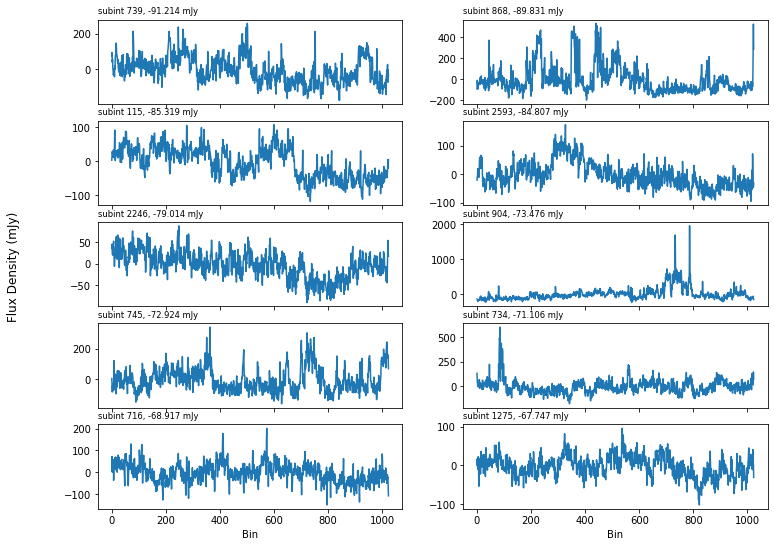

In [26]:
#plot these pulses
fig, axes = plt.subplots(nrows=5, ncols=2, sharex = True, figsize=(12, 9))
d = flt_data.sort("area").select(["subint", "bg_subtr_amp", "area"]).collect()

def find_ax(x):
    ax = list()
    ax.append(x//2)
    
    if np.mod(x, 2) == 0:
        ax.append(0)
    else:
        ax.append(1)
    
    return ax

for i, subint in enumerate(d["subint"][:10]):
    f_ax = find_ax(i)
    plot = sns.lineplot(d["bg_subtr_amp"][i], ax=axes[f_ax[0], f_ax[1]])
    plot.set(xlabel="Bin")
    S_mean = d["area"][i]
    plot.set_title(f"subint {subint}, {S_mean:.3f} mJy", fontsize='small', loc='left')

fig.supylabel("Flux Density (mJy)")

# 6. Flux Density Distribution and Modeling

Text(0.5, 0, 'Flux Density (mJy)')

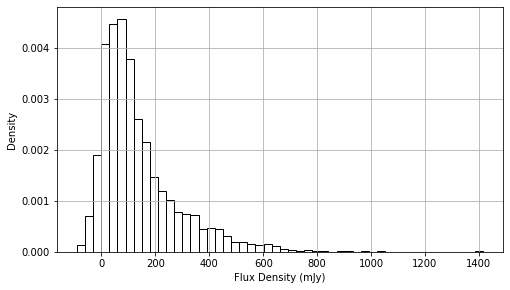

In [27]:
#plot histogram of flux density
plt.figure(figsize=(8, 4.5))

area = flt_data.select("area").collect()["area"]

sns.histplot(area, stat='density', linewidth=1, bins=50, fill=False, color='#000000', alpha=1)
plt.grid()
plt.xlabel("Flux Density (mJy)")

In [28]:
# Normal Model
models = []

with pm.Model() as model:
    w = pm.Dirichlet("w", a=np.array([0.50, 0.50]))

    mu = pm.Normal("mu", mu=550, sigma=1000)
    sigma_1 = pm.HalfNormal("sigma_1", sigma=120*np.sqrt(np.pi/2))

    sigma_2 = pm.HalfNormal("sigma_2", sigma=100)

    components = [
        pm.Normal.dist(mu=mu, sigma=sigma_1),
        pm.Normal.dist(mu=0, sigma=sigma_2),
    ]

    norm_norm = pm.Mixture("norm_norm", w=w, comp_dists=components, observed=area)

    idata = pm.sample(draws=10000, tune=2000, chains=4)
    idata.extend(pm.compute_log_likelihood(idata, model=model))
    models.append(model)
    idata_norm = idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, mu, sigma_1, sigma_2]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 52 seconds.


In [29]:
az.summary(idata_norm, hdi_prob=0.68)

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,177.125,4.604,172.490,181.580,0.030,0.021,23938.0,29209.0,1.0
w[0],0.735,0.020,0.715,0.754,0.000,0.000,20287.0,25315.0,1.0
w[1],0.265,0.020,0.246,0.285,0.000,0.000,20287.0,25315.0,1.0
sigma_1,152.981,2.519,150.491,155.485,0.015,0.010,28991.0,30333.0,1.0
sigma_2,47.720,2.835,44.848,50.462,0.018,0.013,24040.0,26739.0,1.0


In [30]:
az.loo(idata_norm)

Computed from 40000 posterior samples and 2722 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -17322.54    62.22
p_loo        6.36        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2722  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [31]:
# Log-Normal Model
with pm.Model() as model:
    w = pm.Dirichlet("w", a=np.array([0.50, 0.50]))

    mu = pm.Normal("mu", mu=6.241, sigma=1000)
    sigma_1 = pm.HalfNormal("sigma_1", sigma=0.2244*np.sqrt(np.pi/2))

    sigma_2 = pm.HalfNormal("sigma_2", sigma=100)

    components = [
        pm.LogNormal.dist(mu=mu, sigma=sigma_1),
        pm.Normal.dist(mu=0, sigma=sigma_2),
    ]

    log_norm_norm = pm.Mixture("log_norm_norm", w=w, comp_dists=components, observed=area)
    idata = pm.sample(draws=10000, tune=2000, chains=4)
    idata.extend(pm.compute_log_likelihood(idata, model=model))
    models.append(model)
    idata_lognorm = idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, mu, sigma_1, sigma_2]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 43 seconds.


In [32]:
az.summary(idata_lognorm, hdi_prob=0.68)

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.833,0.021,4.814,4.856,0.000,0.000,32970.0,31708.0,1.0
w[0],0.795,0.010,0.785,0.805,0.000,0.000,34367.0,33241.0,1.0
w[1],0.205,0.010,0.195,0.215,0.000,0.000,34367.0,33241.0,1.0
sigma_1,0.814,0.016,0.797,0.829,0.000,0.000,40376.0,34285.0,1.0
sigma_2,27.845,1.116,26.625,28.835,0.005,0.004,47926.0,32056.0,1.0


In [33]:
az.loo(idata_lognorm)

Computed from 40000 posterior samples and 2722 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -16766.41    51.36
p_loo        4.36        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2722  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [34]:
# Gamma Model
with pm.Model() as model:
    w = pm.Dirichlet("w", a=np.array([0.50, 0.50]))

    alpha = pm.HalfNormal("alpha", sigma=(526.3/119.6)**2 * np.sqrt(np.pi/2))
    beta = pm.HalfNormal("beta", sigma=526.3/(119.6**2) * np.sqrt(np.pi/2))
    
    # This is a fix for PyMC < 5.9.0, for PyMC >= 5.9.0, remove this line. #
    beta = pt.tensor.math.reciprocal(beta)

    sigma = pm.HalfNormal("sigma", sigma=100)

    components = [
        pm.Gamma.dist(alpha=alpha, beta=beta),
        pm.Normal.dist(mu=0, sigma=sigma),
    ]

    gamma_norm = pm.Mixture("gamma_norm", w=w, comp_dists=components, observed=area)
    idata = pm.sample(draws=10000, tune=2000, chains=4)
    idata.extend(pm.compute_log_likelihood(idata, model=model))
    models.append(model)
    idata_gamma = idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, alpha, beta, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 79 seconds.


In [35]:
az.summary(idata_gamma, hdi_prob=0.68)

,mean,sd,hdi_16%,hdi_84%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.827,0.010,0.816,0.837,0.000,0.000,27166.0,25354.0,1.0
w[1],0.173,0.010,0.163,0.184,0.000,0.000,27166.0,25354.0,1.0
alpha,1.425,0.062,1.367,1.489,0.000,0.000,17040.0,19081.0,1.0
beta,0.009,0.000,0.008,0.009,0.000,0.000,17996.0,19761.0,1.0
sigma,31.090,1.505,29.449,32.420,0.009,0.006,31046.0,24875.0,1.0


In [37]:
az.loo(idata_gamma)

Computed from 40000 posterior samples and 2722 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -16784.80    50.12
p_loo        4.89        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2722  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [38]:
#comparison between models
comp_loo = az.compare({"normal": idata_norm, "log-normal": idata_lognorm, "gamma": idata_gamma})
comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
log-normal,0,-16766.406076,4.363620,0.000000,0.675441,51.364719,0.000000,False,log
gamma,1,-16784.798575,4.891119,18.392499,0.323714,50.116834,10.380121,False,log
normal,2,-17322.542101,6.362368,556.136025,0.000845,62.223725,43.591317,False,log


# 7. Model Distribution Plot

(-91.21402444208125, 1413.957574791912)

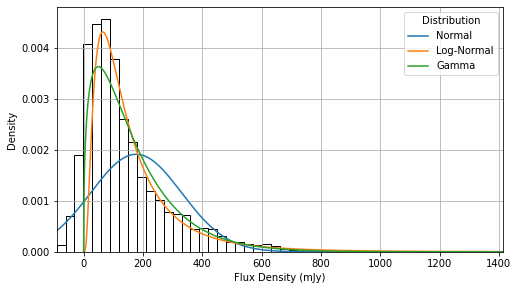

In [44]:
plt.figure(figsize=(8, 4.5))

sns.histplot(area, stat='density', linewidth=1, bins=50, fill=False, color='#000000', alpha=1)

w_norm = idata_norm.posterior.w.mean(axis=0).mean(axis=0).values
w_lognorm = idata_lognorm.posterior.w.mean(axis=0).mean(axis=0).values
w_gamma = idata_gamma.posterior.w.mean(axis=0).mean(axis=0).values

ran = np.linspace(area.min(), area.max(), 10000)
ran_2 = np.linspace(0, area.max(), 10000)
plt.plot(ran, stats.norm.pdf(ran, idata_norm.posterior.mu.mean(), idata_norm.posterior.sigma_1.mean()) * w_norm[0], label="Normal", linewidth=1.5, c='tab:blue')
plt.plot(ran_2, stats.lognorm.pdf(ran_2, s=idata_lognorm.posterior.sigma_1.mean(), scale=np.exp(idata_lognorm.posterior.mu.mean())) * w_lognorm[0], label="Log-Normal", linewidth=1.5, c='tab:orange')
plt.plot(ran_2, stats.gamma.pdf(ran_2, idata_gamma.posterior.alpha.mean(), scale=1 / idata_gamma.posterior.beta.mean()) * w_gamma[0], label="Gamma", linewidth=1.5, c='tab:green')
plt.legend(title="Distribution")
plt.grid()
plt.xlabel("Flux Density (mJy)")
plt.xlim(area.min(), area.max())

(-91.21402444208125, 1413.957574791912)

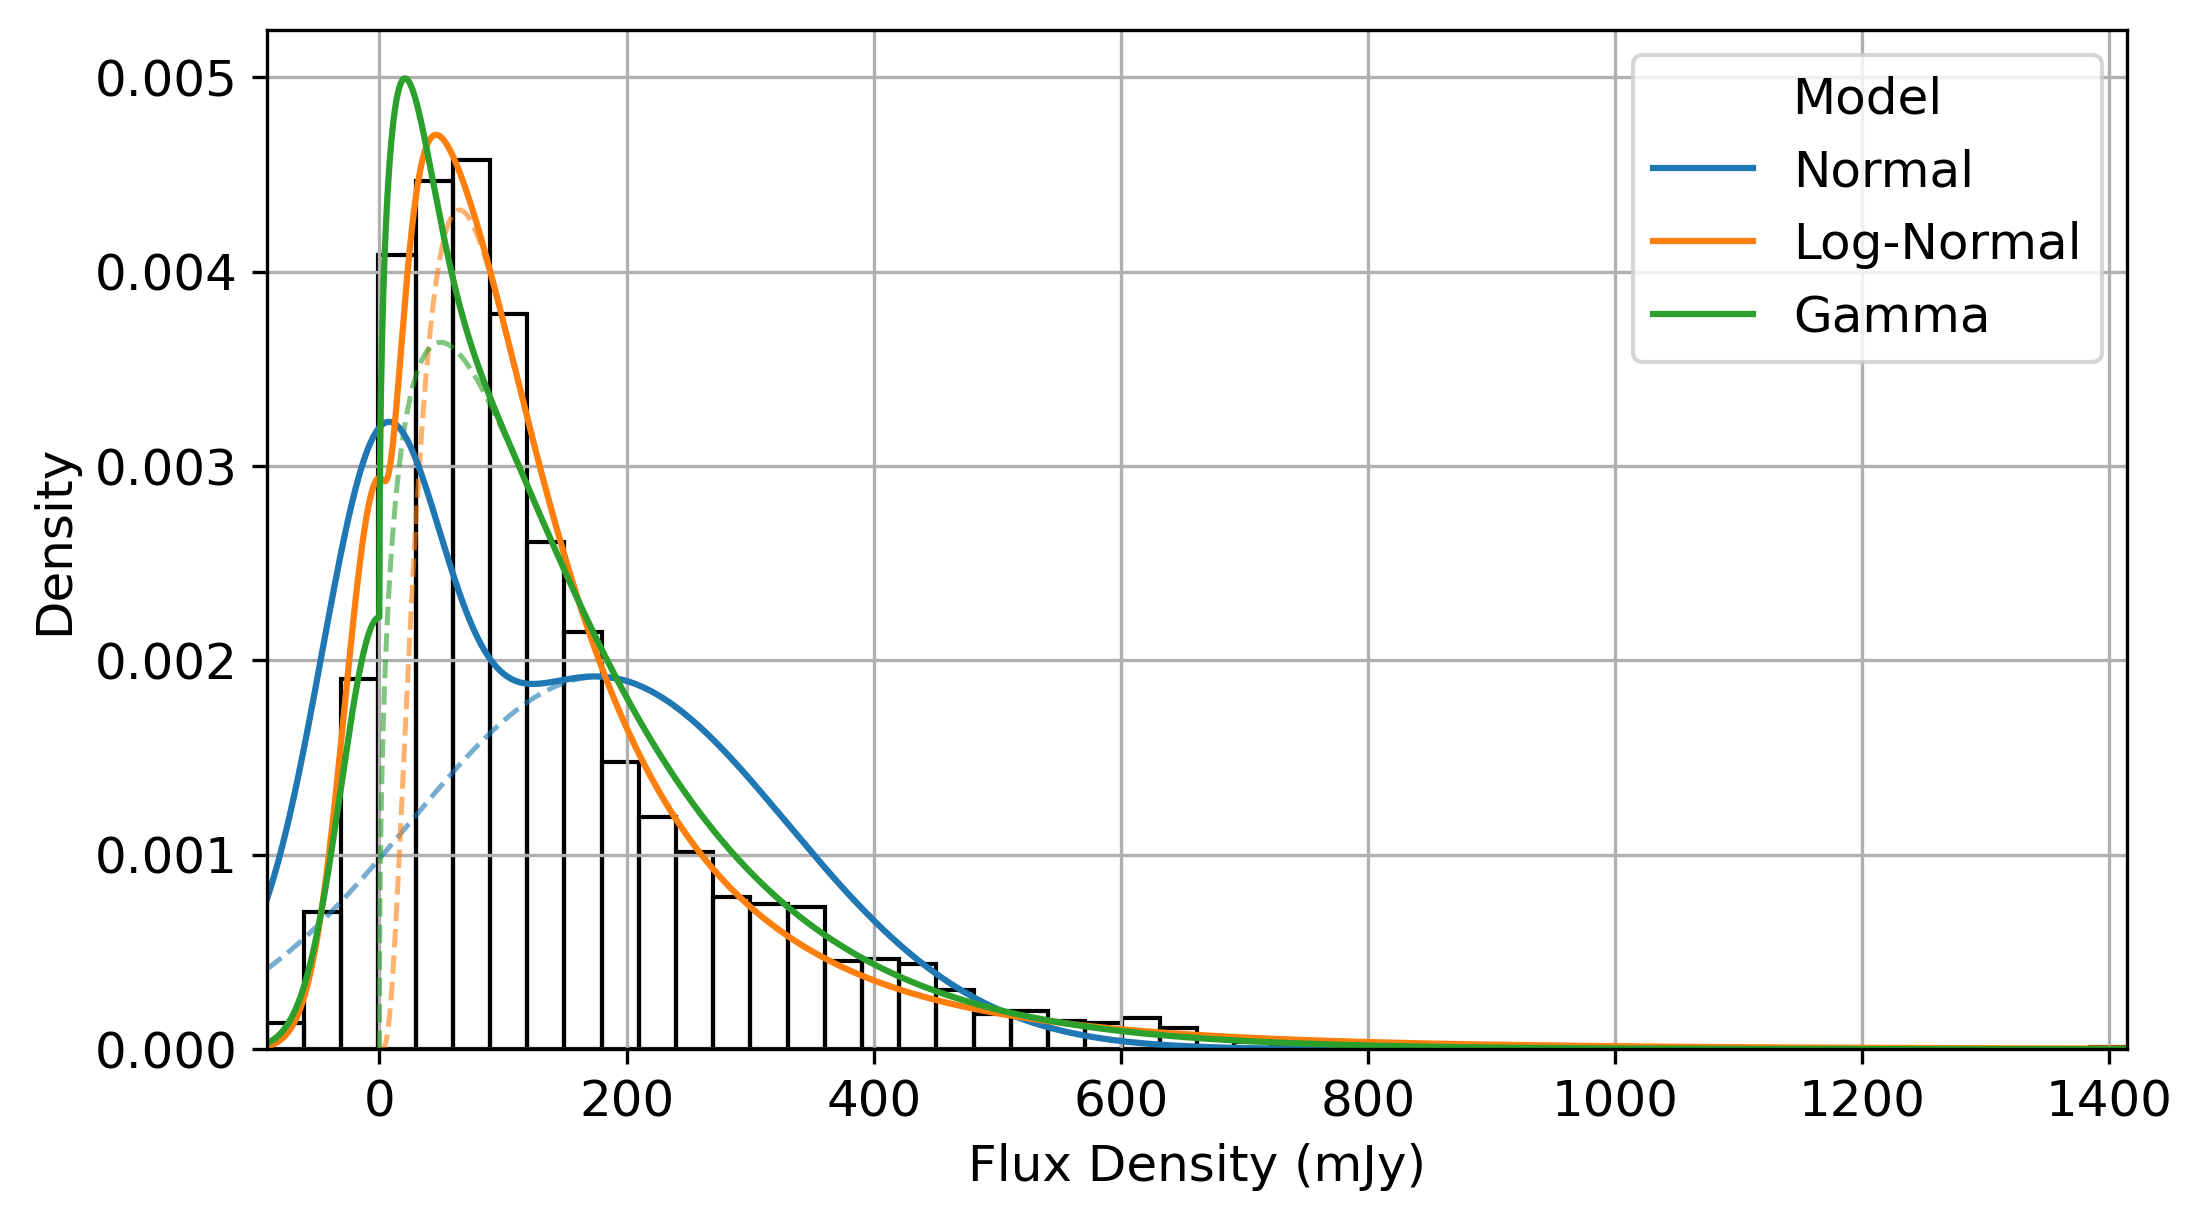

In [47]:
plt.figure(figsize=(8, 4.5))

plt.grid()
sns.histplot(area, stat='density', linewidth=1, bins=50, fill=False, color='#000000', alpha=1)

w_norm = idata_norm.posterior.w.mean(axis=0).mean(axis=0).values
w_lognorm = idata_lognorm.posterior.w.mean(axis=0).mean(axis=0).values
w_gamma = idata_gamma.posterior.w.mean(axis=0).mean(axis=0).values

plt.plot(ran, stats.norm.pdf(ran, idata_norm.posterior.mu.mean(), idata_norm.posterior.sigma_1.mean()) * w_norm[0], linewidth=1.2, linestyle='dashed', c='tab:blue', alpha=0.6)
plt.plot(ran_2, stats.lognorm.pdf(ran_2, s=idata_lognorm.posterior.sigma_1.mean(), scale=np.exp(idata_lognorm.posterior.mu.mean())) * w_lognorm[0], linewidth=1.2, linestyle='dashed', c='tab:orange', alpha=0.6)
plt.plot(ran_2, stats.gamma.pdf(ran_2, idata_gamma.posterior.alpha.mean(), scale=1 / idata_gamma.posterior.beta.mean()) * w_gamma[0], linewidth=1.2, linestyle='dashed', c='tab:green', alpha=0.6)

plt.plot(ran, stats.norm.pdf(ran, idata_norm.posterior.mu.mean(), idata_norm.posterior.sigma_1.mean()) * w_norm[0] + stats.norm.pdf(ran, 0, idata_norm.posterior.sigma_2.mean()) * w_norm[1], label="Normal", linewidth=1.5, c='tab:blue')
plt.plot(ran, stats.lognorm.pdf(ran, s=idata_lognorm.posterior.sigma_1.mean(), scale=np.exp(idata_lognorm.posterior.mu.mean())) * w_lognorm[0] + stats.norm.pdf(ran, 0, idata_lognorm.posterior.sigma_2.mean()) * w_lognorm[1], label="Log-Normal", linewidth=1.5, c='tab:orange')
plt.plot(ran, stats.gamma.pdf(ran, idata_gamma.posterior.alpha.mean(), scale=1/idata_gamma.posterior.beta.mean()) * w_gamma[0] + stats.norm.pdf(ran, 0, idata_gamma.posterior.sigma.mean()) * w_gamma[1], label="Gamma", linewidth=1.5, c='tab:green')
plt.legend(title="Model")
plt.xlabel("Flux Density (mJy)")
plt.xlim(area.min(), area.max())

Text(0.5, 0, 'Flux Density (mJy)')

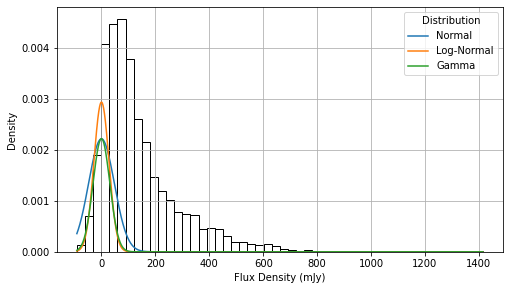

In [41]:
plt.figure(figsize=(8, 4.5))

plt.grid()
sns.histplot(area, stat='density', linewidth=1, bins=50, fill=False, color='#000000', alpha=1)

w_norm = idata_norm.posterior.w.mean(axis=0).mean(axis=0).values
w_lognorm = idata_lognorm.posterior.w.mean(axis=0).mean(axis=0).values
w_gamma = idata_gamma.posterior.w.mean(axis=0).mean(axis=0).values

plt.plot(ran, stats.norm.pdf(ran, 0, idata_norm.posterior.sigma_2.mean()) * w_norm[1], label="Normal", linewidth=1.5)
plt.plot(ran, stats.norm.pdf(ran, 0, idata_lognorm.posterior.sigma_2.mean()) * w_lognorm[1], label="Log-Normal", linewidth=1.5)
plt.plot(ran, stats.norm.pdf(ran, 0, idata_gamma.posterior.sigma.mean()) * w_gamma[1], label="Gamma", linewidth=1.5)
plt.legend(title="Distribution")
plt.xlabel("Flux Density (mJy)")

# 8. Kolmogorov–Smirnov Test

In [42]:
# Main Distribution Only
def cdf_norm(x):
    return [stats.norm.cdf(i, idata_norm.posterior.mu.mean(), idata_norm.posterior.sigma_1.mean()) for i in x]

def cdf_lognorm(x):
    return [stats.lognorm.cdf(i, s=idata_lognorm.posterior.sigma_1.mean(), scale=np.exp(idata_lognorm.posterior.mu.mean())) for i in x]

def cdf_gamma(x):
    return [stats.gamma.cdf(i, idata_gamma.posterior.alpha.mean(), scale=1/idata_gamma.posterior.beta.mean()) for i in x]

print(stats.kstest(area, cdf_norm))
print(stats.kstest(area, cdf_lognorm))
print(stats.kstest(area, cdf_gamma))

KstestResult(statistic=0.24367064243229158, pvalue=8.838532590546864e-143, statistic_location=137.33775575993525, statistic_sign=1)
KstestResult(statistic=0.17755895447978515, pvalue=1.529010071815834e-75, statistic_location=37.87911075011039, statistic_sign=1)
KstestResult(statistic=0.13241472678077382, pvalue=4.446612515172819e-42, statistic_location=106.69532015642477, statistic_sign=1)


In [43]:
#Total Model (Include Noise Distribution)
def cdf_norm(x):
    return [stats.norm.cdf(i, idata_norm.posterior.mu.mean(), idata_norm.posterior.sigma_1.mean()) * w_norm[0] + stats.norm.cdf(i, 0, idata_norm.posterior.sigma_2.mean()) * w_norm[1] for i in x]

def cdf_lognorm(x):
    return [stats.lognorm.cdf(i, s=idata_lognorm.posterior.sigma_1.mean(), scale=np.exp(idata_lognorm.posterior.mu.mean())) * w_lognorm[0] + stats.norm.cdf(i, 0, idata_lognorm.posterior.sigma_2.mean()) * w_lognorm[1] for i in x]

def cdf_gamma(x):
    return [stats.gamma.cdf(i, idata_gamma.posterior.alpha.mean(), scale=1/idata_gamma.posterior.beta.mean()) * w_gamma[0] + stats.norm.cdf(i, 0, idata_gamma.posterior.sigma.mean()) * w_gamma[1] for i in x]

print(stats.kstest(area, cdf_norm))
print(stats.kstest(area, cdf_lognorm))
print(stats.kstest(area, cdf_gamma))


KstestResult(statistic=0.13953723770881388, pvalue=1.0677859972690168e-46, statistic_location=-3.269731173844567, statistic_sign=-1)
KstestResult(statistic=0.019575641111325592, pvalue=0.24465107541360875, statistic_location=305.9410449792464, statistic_sign=-1)
KstestResult(statistic=0.03416787068048044, pvalue=0.003392014247384626, statistic_location=112.01255871073741, statistic_sign=1)
